# **SUDOKO SOLVER**

To construct a sudoko solver the following steps are executed:

1) Process the image.

2) Extract the cells.

3) Consturct a CNN model.

4) Predict each digit of the sudoko cell.

5) Fill the blank cells of the sudoko.



# **Processing the image**

In [202]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import pandas as pd

In [285]:
image= files.upload()

Saving sudoku.jpg to sudoku.jpg


In [286]:
#Reading the image
# image= cv2.imread('download3.png')
image= cv2.imread('sudoku.jpg')
img=image.copy()

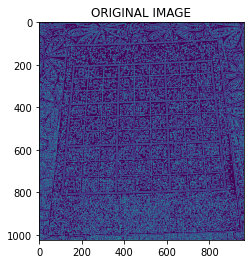

In [287]:
#Coverting the image into grayscale image

gray= cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

#Applying adaptive threshold to make it binary

gray= cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 3)
# gray= cv2.fastNlMeansDenoising(gray, None, 20, 7, 21) 

# blur = cv2.GaussianBlur( gray, (5,5), 0)
# smooth = cv2.addWeighted( blur, 0.5, gray, -0.5, 0)
# gray=smooth

original_image=gray.copy()
gray= cv2.Canny(gray, 50,200)
# kernel = np.ones((2,2),np.uint8)
# gray = cv2.erode(gray,kernel,iterations = 1)
# gray = cv2.blur(gray,(5,5))




plt.imshow(gray)
plt.title('ORIGINAL IMAGE')
plt.show()

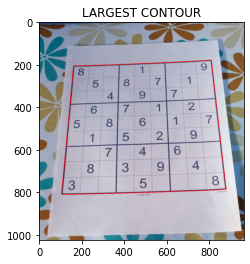

In [288]:
#Find the contours of the image
contours, hierarchy= cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)

#Sort the contours and take the largest contour
sorted_contours= sorted(contours, key=cv2.contourArea, reverse= True)
for i in range(0,5):
  cnt=sorted_contours[i]
  peri = cv2.arcLength(cnt, True)
  app = cv2.approxPolyDP(cnt, 0.01 * peri, True)
  if len(app)==4:
    largest_item=cnt
    break


cv2.drawContours(image, largest_item, -1, (255,0,0),2)
plt.imshow(image)
plt.title('LARGEST CONTOUR')
plt.show()

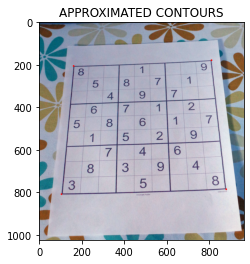

In [289]:
#approxximate the largest contour to a quadrilateral
peri = cv2.arcLength(largest_item, True)
app = cv2.approxPolyDP(largest_item, 0.01 * peri, True)

cv2.drawContours(img, app, -1, (255,0,0),7)

plt.imshow(img)
plt.title('APPROXIMATED CONTOURS')
plt.show()

In [290]:
#Find the sum and diff of the 4 corners
app=(app.reshape(4,2))
rect=np.zeros((4,2),dtype='float32')
diff=np.diff(app,axis=1)
summ=(app.sum(axis=1))

#The top-left will have min sum and bottom right will have maximum sum
rect[0]=app[np.argmin(summ)]
rect[2]=app[np.argmax(summ)]

#The bottom-left will have min diff and top right will have maximum diff
rect[1]=app[np.argmin(diff)]
rect[3]=app[np.argmax(diff)]

print(rect)

[[162. 206.]
 [809. 179.]
 [878. 785.]
 [105. 808.]]


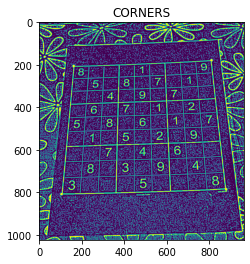

In [291]:
a=rect[0]#TL
b=rect[1]#BL
c=rect[3]#BR
d=rect[2]#TR

#plotting the 4 corners
img_cord=np.float32([a,b,c,d]) # TL, BL, BR, TR
for x in range(0,4):
    cv2.circle(original_image,(int(img_cord[x][0]),int(img_cord[x][1])),7,(255,0,0),-1)
    
plt.imshow(original_image)
plt.title('CORNERS')
plt.show()

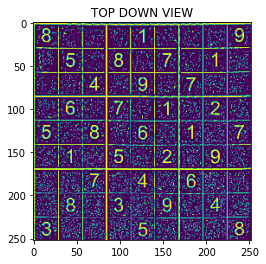

In [292]:
#Applying warp perspective to convert it into birds eye view or to down view
height,width=252,252

new_img_cod=np.float32([[0,0],[width+1,0],[0,height+1],[width+1,height+1]])
    
p=cv2.getPerspectiveTransform(img_cord,new_img_cod)

perspective=cv2.warpPerspective(original_image,p,(width,height))
process_image=perspective.copy()
process_image= cv2.fastNlMeansDenoising(process_image, None, 20, 7, 21)
  
plt.imshow(process_image)
plt.title('TOP DOWN VIEW')
plt.show()

In [293]:
process_image.shape

(252, 252)

# **EXTRACTING THE CELLS**

In [294]:
sudoku=process_image
size=252
sudoku=sudoku/255.
cells = []
cell_shape = size // 9
for i in range(9):
  i = cell_shape * i
  for j in range(9):
    j = j * cell_shape
    cell = sudoku[i: i+cell_shape, j: j+cell_shape]

    #cleaning the cell as it may have unwanted noise or distorted pixels
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (2,2))
    cell = cv2.morphologyEx(cell, cv2.MORPH_CLOSE, kernel)
    cell = cv2.morphologyEx(cell, cv2.MORPH_OPEN, kernel)
    cell = cv2.fastNlMeansDenoising((cell*255).astype(np.uint8), None, 20, 7, 21) 


    cells.append(cell)

cells_image=np.array(cells)

In [295]:
cells_image.shape

(81, 28, 28)

In [296]:
# sample=cells_image[2][5:252,5:252]
#   # blur = cv2.medianBlur(sample, 3)
# blur = cv2.GaussianBlur( sample, (1,1), 0)

# thresh= cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,19, 3)
#   # edge= cv2.Canny(thresh, 50,200)

#   # kernel = np.ones((2,2),np.uint8)
#   # erode = cv2.erode(thresh,kernel,iterations = 1)

#   # kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1,1))
#   # close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

# plt.imshow(thresh)

In [297]:

# CENTERING EACH CELL

k=0
for i in range(9):
  for j in range(9):
    img=cells_image[k]
    img=img[5:252,5:252]
    cells_image[k]= img=cv2.resize(img,(28,28),interpolation = cv2.INTER_AREA)
    k+=1

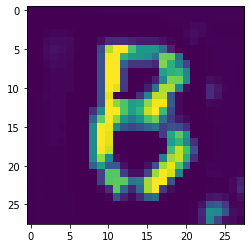

In [313]:
plt.imshow(cells_image[0])

In [315]:

#CHECKING FOR BLANKNESS OF IMAGE

summ=cells_image[0].sum()
print(summ)
if summ>12000:
  print('not blank')
else:
  print('blank')

27877
not blank


# **ANN model for Digit recognition**

In [120]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import itertools
from tensorflow.keras.layers import Dense, Conv2D, Input,Flatten,Dropout,MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

In [121]:
minst=tf.keras.datasets.mnist

In [122]:
(x_train,y_train),(x_test,y_test)=minst.load_data()

11501568/11490434 [==============================] - 0s 0us/step


# **Removing zero label from the MNIST dataset as we need only numbers from 1-9**

In [123]:
zero1= np.where(y_train==0)
zero1 = zero1[0]
zero2= np.where(y_test==0)
zero2 = zero2[0]

In [124]:
x_train=x_train.reshape(60000,784)
x_test=x_test.reshape(10000,784)
df=pd.DataFrame(x_train)
df2=pd.DataFrame(x_test)

In [125]:
x_train=df.drop(zero1,axis=0)
x_train=x_train.to_numpy().reshape(54077,28,28)
y_train=np.delete(y_train,zero1)

x_test=df2.drop(zero2,axis=0)
x_test=x_test.to_numpy().reshape(9020,28,28)
y_test=np.delete(y_test,zero2)

In [126]:
x_train=x_train/255.0
x_test=x_test/255.0
x_train.shape

(54077, 28, 28)

In [127]:
# data is 2D so we need to expand
# CNN needs H*W*C
x_train=np.expand_dims(x_train,-1)
x_train.shape

(54077, 28, 28, 1)

In [128]:
k=len(set(y_train))
k

9

In [129]:
set(y_train)
x_train[0].shape

(28, 28, 1)

# Building the CNN model

In [265]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(5,5), padding='same', activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(64, kernel_size=(5,5), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dropout(0.4),

    tf.keras.layers.Conv2D(128, kernel_size=(5,5), padding='same', activation='relu'),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [266]:
model.compile(optimizer = tf.keras.optimizers.Adam(0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])


In [267]:
data_augmentation = ImageDataGenerator(
        rotation_range=10,  
        zoom_range = 0.10,  
        width_shift_range=0.1, 
        height_shift_range=0.1)

In [268]:

r= model.fit(data_augmentation.flow(x_train, y_train, batch_size=64),
                    epochs=10,
                    validation_data=(x_test,y_test),
                    steps_per_epoch = x_train.shape[0]/100,
                   )

Epoch 1/10
540/540 [==============================] - 15s 27ms/step - loss: 0.8787 - accuracy: 0.7160 - val_loss: 0.4920 - val_accuracy: 0.8445
Epoch 2/10
540/540 [==============================] - 14s 26ms/step - loss: 0.3131 - accuracy: 0.9059 - val_loss: 0.0568 - val_accuracy: 0.9815
Epoch 3/10
540/540 [==============================] - 14s 26ms/step - loss: 0.2285 - accuracy: 0.9331 - val_loss: 0.0384 - val_accuracy: 0.9870
Epoch 4/10
540/540 [==============================] - 14s 27ms/step - loss: 0.1944 - accuracy: 0.9444 - val_loss: 0.0414 - val_accuracy: 0.9873
Epoch 5/10
540/540 [==============================] - 16s 29ms/step - loss: 0.1763 - accuracy: 0.9513 - val_loss: 0.0345 - val_accuracy: 0.9890
Epoch 6/10
540/540 [==============================] - 14s 26ms/step - loss: 0.1643 - accuracy: 0.9539 - val_loss: 0.0294 - val_accuracy: 0.9889
Epoch 7/10
540/540 [==============================] - 14s 26ms/step - loss: 0.1480 - accuracy: 0.9578 - val_loss: 0.0304 - val_accuracy:

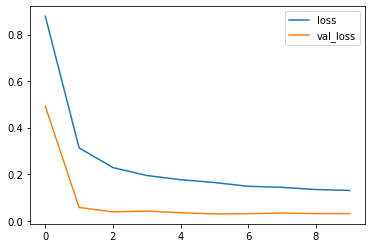

In [269]:
plt.plot(r.history['loss'],label='loss')
plt.plot(r.history['val_loss'],label='val_loss')
plt.legend()

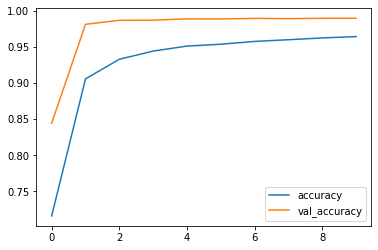

In [270]:
plt.plot(r.history['accuracy'],label='accuracy')
plt.plot(r.history['val_accuracy'],label='val_accuracy')
plt.legend()

In [271]:
print(model.evaluate(x_test,y_test))

282/282 [==============================] - 1s 5ms/step - loss: 0.0309 - accuracy: 0.9899
[0.030945852398872375, 0.9899113178253174]


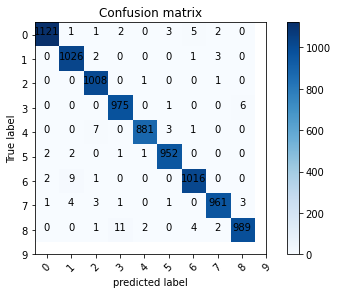

In [319]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
  

  plt.imshow(cm,interpolation='nearest',cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)

  fmt='.2f' if normalize else 'd'
  thresh=cm.max()/.2
  for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
    plt.text(j,i,format(cm[i,j],fmt),
             ha="center",
             color='white' if cm[i,j]> thresh else 'black')

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('predicted label')
  plt.show

p_test=model.predict(x_test).argmax(axis=1)
cm=confusion_matrix(y_test,p_test)
plot_confusion_matrix(cm,list(range(10)))

In [320]:
print(cm)

[[1121    1    1    2    0    3    5    2    0]
 [   0 1026    2    0    0    0    1    3    0]
 [   0    0 1008    0    1    0    0    1    0]
 [   0    0    0  975    0    1    0    0    6]
 [   0    0    7    0  881    3    1    0    0]
 [   2    2    0    1    1  952    0    0    0]
 [   2    9    1    0    0    0 1016    0    0]
 [   1    4    3    1    0    1    0  961    3]
 [   0    0    1   11    2    0    4    2  989]]


Text(0.5, 1.0, 'True label: 7 Predicted: 2 ')

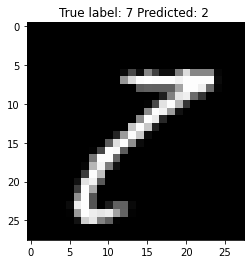

In [273]:
misclassified_idx=np.where(p_test!=y_test)[0]
# misclassified_idx[:10]
i=np.random.choice(misclassified_idx)
plt.imshow(x_test[i],cmap='gray')
plt.title('True label: %s Predicted: %s '%(y_test[i],p_test[i]))

In [311]:
grid=np.zeros([9,9],dtype='int32')
k=0
for i in range(9):
  for j in range(9):
    img=cells_image[k]
    summ=img.sum()
    k+=1
    if summ >12000:
      dig_pred=model.predict(img.reshape(1,28,28,1)).argmax(axis=1)
      grid[i][j]=dig_pred
    else:
      grid[i][j]=0

grid

array([[8, 0, 0, 0, 7, 0, 0, 0, 9],
       [0, 5, 0, 8, 0, 7, 0, 7, 0],
       [0, 0, 4, 0, 4, 0, 7, 0, 0],
       [0, 5, 0, 7, 0, 7, 0, 2, 0],
       [5, 0, 8, 0, 6, 0, 7, 0, 7],
       [0, 7, 0, 5, 0, 2, 0, 9, 0],
       [0, 0, 7, 0, 4, 0, 8, 0, 0],
       [0, 8, 0, 3, 0, 4, 0, 4, 0],
       [3, 0, 0, 0, 5, 0, 0, 0, 4]], dtype=int32)

In [316]:
i=4
img=cells_image[i]
dig_pred=model.predict(img.reshape(1,28,28,1)).argmax(axis=1)

In [317]:
dig_pred

array([7])

Text(0.5, 1.0, ' Predicted: [7] ')

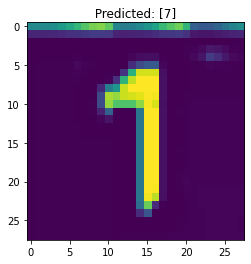

In [318]:
plt.imshow(img)
plt.title(' Predicted: %s '%(dig_pred))